# Loading Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(12, 5)},
        font_scale=1.5,
        style="whitegrid")
        
from pyspark.sql import HiveContext
from pyspark.sql import SQLContext

# initialize session hive and sql environments
hiveContext = HiveContext(sc)
sqlContext = SQLContext(sc)

# Data Reading

In [3]:
project_folder = "../"
datapath = project_folder + "data/"
plotpath = project_folder + "graphs/"
mungepath = project_folder + "munge/"
configpath = project_folder + "config/"
diagnostic = project_folder + "diagnostic/"
modelpath = project_folder + "model/"
output = project_folder + "output/"

In [4]:
from pyspark.sql.functions import col

train = spark.read.csv(os.path.join(datapath,"train.csv"), header=True)
print('Found %d observations in training set.' %train.count())

Found 184903890 observations in training set.


In [5]:
from pyspark.sql.functions import col

test_old = (spark.read.csv(os.path.join(datapath,"test_supplement.csv"), header=True)
            .filter(col('click_time') >= '2017-11-09 16:00:00'))

print('Found %d observations in test_old set.' %test_old.count())

Found 57536872 observations in test_old set.


In [6]:
train.show(10)

+------+---+------+---+-------+-------------------+---------------+-------------+
|    ip|app|device| os|channel|         click_time|attributed_time|is_attributed|
+------+---+------+---+-------+-------------------+---------------+-------------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|           null|            0|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|           null|            0|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|           null|            0|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|           null|            0|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|           null|            0|
| 18787|  3|     1| 16|    379|2017-11-06 14:36:26|           null|            0|
|103022|  3|     1| 23|    379|2017-11-06 14:37:44|           null|            0|
|114221|  3|     1| 19|    379|2017-11-06 14:37:59|           null|            0|
|165970|  3|     1| 13|    379|2017-11-06 14:38:10|           null|            0|
| 74544| 64|    

In [7]:
train.printSchema()

root
 |-- ip: string (nullable = true)
 |-- app: string (nullable = true)
 |-- device: string (nullable = true)
 |-- os: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- click_time: string (nullable = true)
 |-- attributed_time: string (nullable = true)
 |-- is_attributed: string (nullable = true)



# Build the full dataset

In [8]:
# train and test set concatenation
from pyspark.sql.functions import col
data = (train.select('ip', 'app', 'device', 'os', 'channel', 'click_time')
        .unionAll(test_old.select('ip', 'app', 'device', 'os', 'channel', 'click_time')))
        
print('Total number of clicks in one week:', data.count())

Total number of clicks in one week: 242440762


In [9]:
data.show(5)

+------+---+------+---+-------+-------------------+
|    ip|app|device| os|channel|         click_time|
+------+---+------+---+-------+-------------------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|
+------+---+------+---+-------+-------------------+
only showing top 5 rows



# Datetime Features

In [10]:
# day function
def get_day(date):
    """
    Returns the hour based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        day: A String containing the day of click ("06", "07", .."10")
    """
    
    return date[8:10]

# hour function
def get_hour(date):
    """
    Returns the hour based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        hour: A String containing the hour interval ("01", "02", .."23")
    """
    
    return date[11:13]

# minute function
def get_minute(date):
    """
    Returns the minute based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        hour: A String containing the minute interval ("01", "02", .."59")
    """
    
    return date[14:16]

In [11]:
# Get datetime features
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

day_udf = udf(get_day, StringType())
hour_udf = udf(get_hour, StringType())
minute_udf = udf(get_minute, StringType())

data = data.withColumn('day', day_udf(data.click_time))
data = data.withColumn('hour', hour_udf(data.click_time))
data = data.withColumn('minute', minute_udf(data.click_time))

In [12]:
data.show(5)

+------+---+------+---+-------+-------------------+---+----+------+
|    ip|app|device| os|channel|         click_time|day|hour|minute|
+------+---+------+---+-------+-------------------+---+----+------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21| 06|  14|    32|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34| 06|  14|    33|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12| 06|  14|    34|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52| 06|  14|    34|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08| 06|  14|    35|
+------+---+------+---+-------+-------------------+---+----+------+
only showing top 5 rows



# IP Number of Clicks for same Device in same Hour

In [13]:
from pyspark.sql.functions import col, unix_timestamp, lit
import pyspark.sql.functions as func

In [14]:
var = 'device'

In [15]:
var_hour_clicks = (data
                   .groupBy(var, 'day', 'hour')
                   .agg(func.count(func.lit(1)).alias(var+'_hour_clicks'),
                        func.round(func.stddev(col('minute')), 2).alias(var+'_hour_std_minute'),
                        func.round(func.mean(col('minute')), 2).alias(var+'_hour_avg_minute'))
                      .fillna({var+'_hour_std_minute':0,
                               var+'_hour_avg_minute':0})
                      .cache())

var_hour_clicks.show(100, truncate=False)

+------+---+----+------------------+----------------------+----------------------+
|device|day|hour|device_hour_clicks|device_hour_std_minute|device_hour_avg_minute|
+------+---+----+------------------+----------------------+----------------------+
|128   |07 |00  |1                 |0.0                   |11.0                  |
|220   |07 |00  |31                |16.1                  |32.06                 |
|313   |07 |00  |4                 |15.73                 |41.75                 |
|94    |07 |22  |1                 |0.0                   |25.0                  |
|234   |07 |22  |12                |19.23                 |27.25                 |
|45    |07 |22  |10                |14.52                 |32.3                  |
|350   |07 |23  |9                 |18.53                 |24.44                 |
|1269  |07 |23  |1                 |0.0                   |4.0                   |
|847   |07 |23  |2                 |0.0                   |14.0                  |
|354

In [16]:
data.filter((col('hour')==0) & (col(var)==313)).show(truncate=False)

+------+---+------+---+-------+-------------------+---+----+------+
|ip    |app|device|os |channel|click_time         |day|hour|minute|
+------+---+------+---+-------+-------------------+---+----+------+
|60972 |19 |313   |24 |213    |2017-11-07 00:24:02|07 |00  |24    |
|153588|19 |313   |24 |333    |2017-11-07 00:33:18|07 |00  |33    |
|64188 |206|313   |24 |320    |2017-11-07 00:55:21|07 |00  |55    |
|64188 |206|313   |24 |320    |2017-11-07 00:55:25|07 |00  |55    |
+------+---+------+---+-------+-------------------+---+----+------+



## Export New Features

In [17]:
(var_hour_clicks
 .coalesce(1)
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"f_"+var+"_hour_clicks", compression="None"))

In [18]:
var_hour_clicks.count()

53535

## Check the impact of new features

In [19]:
import pyspark.sql.functions as func

train.groupBy().agg(func.mean(col('is_attributed'))).show()

+--------------------+
|  avg(is_attributed)|
+--------------------+
|0.002470721410998979|
+--------------------+



In [20]:
train_sample = (train.sample(fraction=0.05, withReplacement=False, seed=22)
                .withColumn('day', day_udf(data.click_time))
                .withColumn('hour', hour_udf(data.click_time))
                .join(var_hour_clicks, [var, 'day', 'hour'], 'left_outer')
                .cache())

In [21]:
train_sample.count()

9248009

In [22]:
train.sample(fraction=0.05, withReplacement=False, seed=22).count()

9248009

In [23]:
train_sample.show(5, truncate=False)

+------+---+----+------+---+---+-------+-------------------+---------------+-------------+------------------+----------------------+----------------------+
|device|day|hour|ip    |app|os |channel|click_time         |attributed_time|is_attributed|device_hour_clicks|device_hour_std_minute|device_hour_avg_minute|
+------+---+----+------+---+---+-------+-------------------+---------------+-------------+------------------+----------------------+----------------------+
|1     |06 |14  |38816 |3  |18 |379    |2017-11-06 14:40:39|null           |0            |48                |7.86                  |45.83                 |
|1     |06 |14  |134575|3  |13 |379    |2017-11-06 14:43:10|null           |0            |48                |7.86                  |45.83                 |
|1     |06 |14  |30986 |3  |19 |379    |2017-11-06 14:52:13|null           |0            |48                |7.86                  |45.83                 |
|1     |06 |15  |199564|3  |13 |379    |2017-11-06 15:09:44|null

In [24]:
features = [var+'_hour_clicks', var+'_hour_std_minute', var+'_hour_avg_minute']

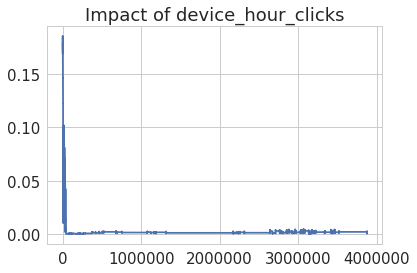

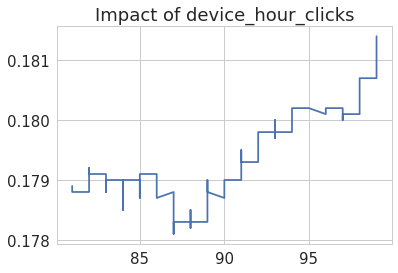

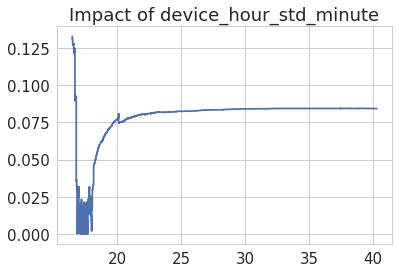

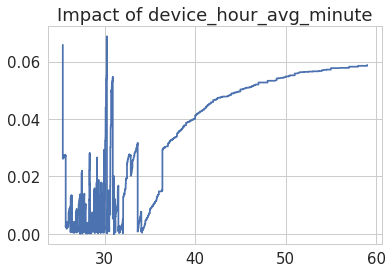

In [25]:
for f in features:
    PDF = train_sample.select('is_attributed', f).toPandas()
    PDF_sorted = PDF.sort_values(by=f)
    PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()
    plt.title('Impact of '+f)
    plt.plot(PDF_sorted[f], PDF_sorted.roll)
    plt.show()
    
    if np.max(PDF_sorted[f])>200:
        PDF_filtered = PDF_sorted[PDF_sorted[f]<100]
        plt.title('Impact of '+f)
        plt.plot(PDF_filtered[f], PDF_filtered.roll)
        plt.show()